In [268]:
import os
import requests
import pandas as pd
import numpy as np
import scipy
import re
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

In [3]:
documentId = "1-IxV9UoncmM1X7LjlGEEmc9PHtqAmnH63Jlv4xTCOp4"
sheetId = 0

# Read data from google spreadsheet

In [17]:
def getSpreadSheet(docId):
    """
    Reads data from google spreadsheet as csv
    
    Inputs
    ======
    docId -- id of the google spreadsheet.  Must be accessible by shared link without authentication.
    
    Outputs
    =======
    csvData -- raw csv data retrieved
    """
    
    requestString = "https://docs.google.com/spreadsheets/d/{DOC_ID}/export?format=csv"
    requestURL = requestString.format(DOC_ID=docId)
    
    requestResult = requests.get(requestURL)
    assert requestResult.status_code == 200 
    csvData = requestResult.content.decode()
    
    return csvData

In [18]:
csvData = getSpreadSheet(documentId)

In [26]:
csvData

'Date,Court,Player1,Player2,Player3,Player4,South,North\r\n2016-09-17,1,Ulric,Kurt,Linh,James,15,21\r\n2016-09-17,1,Kurt,Suzanne,James,Ulric,19,21\r\n2016-09-17,1,Linh,kurt,Suzanne,James,22,20\r\n2016-09-17,1,Linh,Ulric,Suzanne,Frank,21,15\r\n2016-09-17,1,Frank,Ulric,Kurt,James,17,21\r\n2016-09-17,1,Linh,Frank,Suzanne,James,21,13\r\n2016-09-17,1,Linh,Kurt,Ulric,Suzanne,21,17\r\n2016-09-17,1,Frank,Suzanne,James,Kurt,21,13\r\n2016-09-17,1,Ulric,Kurt,Frank,Suzanne,20,22\r\n2016-09-24,1,Ulric,Kurt,Linh,James,16,21\r\n2016-09-24,2,Ulric,Linh,Carmen ,James,15,21\r\n2016-09-24,1,Bri,maceo,kurt,Suzanne,22,20\r\n2016-09-24,1,Linh,Kurt,Bri,Russ,14,21\r\n2016-09-24,2,Carmen ,James,Maceo,Suzanne,17,21\r\n2016-09-24,1,Linh,maceo,Suzanne,Russ,13,21\r\n2016-09-24,2,Bri,Ulric,Kurt,James,18,21\r\n2016-09-24,1,Ulric,maceo,Linh,Russ,14,21\r\n2016-09-24,1,Kurt,Suzanne,Carmen ,Russ,10,21\r\n2016-09-24,1,Ulric,Russ,Linh,Kurt,21,19'

In [43]:
schema = {"Date" : str,
         "Court" : int,
         "Player1" : str,
          "Player2" : str,
          "Player3" : str,
          "Player4" : str,
          "South" : int,
          "North" : int
         }

def parseCsvData(csvData, schema=None):
    """
    """
    dfData = pd.read_csv(StringIO(csvData), dtype=schema)
    
    return dfData

dfData = parseCsvData(csvData, schema)

In [42]:
dfData.dtypes

Date       object
Court       int32
Player1    object
Player2    object
Player3    object
Player4    object
South       int32
North       int32
dtype: object

In [61]:
def preProcessData(df):
    dfProcessed = df.copy()
    dfProcessed["Date"] = pd.to_datetime(dfProcessed["Date"])
#     dfProcessed["Player1"] = dfProcessed["Player1"].astype(str)

    def cleanName(name):
        cleanedName = name.lower().strip()
        return cleanedName
    
    dfProcessed["Player1"] = dfProcessed["Player1"].apply(cleanName)
    dfProcessed["Player2"] = dfProcessed["Player2"].apply(cleanName)
    dfProcessed["Player3"] = dfProcessed["Player3"].apply(cleanName)
    dfProcessed["Player4"] = dfProcessed["Player4"].apply(cleanName)
    
    return dfProcessed

dfProcessed = preProcessData(dfData)

In [59]:
dfProcessed.dtypes

Date       datetime64[ns]
Court               int32
Player1            object
Player2            object
Player3            object
Player4            object
South               int32
North               int32
dtype: object

In [62]:
dfProcessed

,Date,Court,Player1,Player2,Player3,Player4,South,North
0,2016-09-17,1,ulric,kurt,linh,james,15,21
1,2016-09-17,1,kurt,suzanne,james,ulric,19,21
2,2016-09-17,1,linh,kurt,suzanne,james,22,20
3,2016-09-17,1,linh,ulric,suzanne,frank,21,15
4,2016-09-17,1,frank,ulric,kurt,james,17,21
5,2016-09-17,1,linh,frank,suzanne,james,21,13
6,2016-09-17,1,linh,kurt,ulric,suzanne,21,17
7,2016-09-17,1,frank,suzanne,james,kurt,21,13
8,2016-09-17,1,ulric,kurt,frank,suzanne,20,22
9,2016-09-24,1,ulric,kurt,linh,james,16,21


# Feature Engineering

In [78]:
def createPlayerDict(df):
    uniquePlayers = set(df["Player1"].tolist() +\
                    df["Player2"].tolist() +\
                    df["Player3"].tolist() +\
                    df["Player4"].tolist())
    
    uniquePlayersDict = dict(zip(uniquePlayers, range(len(uniquePlayers))))
    
    return uniquePlayersDict

playerDict = createPlayerDict(dfProcessed)

playerDict

{'bri': 0,
 'carmen': 4,
 'frank': 5,
 'james': 3,
 'kurt': 9,
 'linh': 1,
 'maceo': 6,
 'russ': 8,
 'suzanne': 2,
 'ulric': 7}

In [198]:
revPlayerDict = {v : k for k, v in playerDict.items()}
revPlayerDict

{0: 'bri',
 1: 'linh',
 2: 'suzanne',
 3: 'james',
 4: 'carmen',
 5: 'frank',
 6: 'maceo',
 7: 'ulric',
 8: 'russ',
 9: 'kurt'}

In [154]:
def teamToVector(teamSeries, playerDict):
    teamVector = np.zeros(len(playerDict))
    teamVector[playerDict[teamSeries[0]]] = 1
    teamVector[playerDict[teamSeries[1]]] = 1
    
    return teamVector

teamToVector(("ulric", "kurt"), playerDict)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.])

In [215]:
def engFeatures(df, playerDictionary):
    dfFeatures = df.copy()
    
    dfFeatures["team1Names"] = dfFeatures.loc[:, ["Player1", "Player2"]].apply(lambda x: (x[0], x[1]), axis="columns")
    dfFeatures["team2Names"] = dfFeatures.loc[:, ["Player3", "Player4"]].apply(lambda x: (x[0], x[1]), axis="columns")
    
    dfFeatures["team1Vector"] = dfFeatures["team1Names"].apply(lambda x: teamToVector(x, playerDictionary))
    dfFeatures["team2Vector"] = dfFeatures["team2Names"].apply(lambda x: teamToVector(x, playerDictionary))
    
#     dfFeatures.drop(["Player1", "Player2", "Player3", "Player4"], axis="columns", inplace=True)
                                             
    return dfFeatures
    
dfFeatures = engFeatures(dfProcessed, playerDict)

# Model data

In [188]:
from sklearn import linear_model
import statsmodels.api as sm

### Simple model

First model each team's score as a function of the players on the team

$score = \sum^{k}_{i = 0} \beta_i player_i$

This model ignores: 
* interactions between players on the same team
* interactions with the opposing team

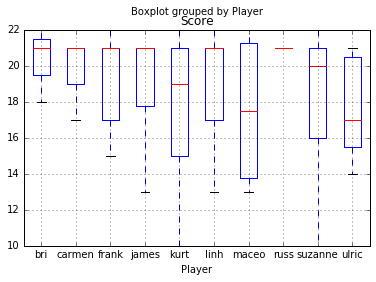

In [251]:
def boxPlots(df, playerList=None):
    
    # flatten players and scores
    dfFlattenedData = pd.concat([df.loc[:, ["Player1","South"]].rename(columns={"Player1" : "Player", "South" : "Score"}),
                            df.loc[:, ["Player2","South"]].rename(columns={"Player2" : "Player", "South" : "Score"}),
                            df.loc[:, ["Player3","North"]].rename(columns={"Player3" : "Player", "North" : "Score"}),
                            df.loc[:, ["Player4","North"]].rename(columns={"Player4" : "Player", "North" : "Score"}),
                            ])

    dfPlotData = dfFlattenedData
    
    if playerList:
        playerFilter = dfFlattenedData["Player"].isin(playerList)
        dfPlotData = dfFlattenedData.loc[playerFilter]
    
    dfPlotData.boxplot(column="Score", by="Player")
        
        
boxPlots(dfFeatures)

In [352]:
dfTeams = pd.concat([dfFeatures.loc[:, ["team1Vector", "South"]].rename(columns={"team1Vector" : "teamVector",
                                                                     "South" : "Score"}),
                     dfFeatures.loc[:, ["team2Vector", "North"]].rename(columns={"team2Vector" : "teamVector",
                                                                     "North" : "Score"})
                     ])

In [357]:
X = np.vstack(dfTeams["teamVector"].values)
Y = dfTeams["Score"].values

In [358]:
lrModel = linear_model.LinearRegression()
lrModel.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [392]:
def getModelParameters(model, playerDict, teamDict=None):
    results = {}
    results["intercept"] = model.intercept_
    results["coefficients"] = {}
    
    coefDict = playerDict.copy()
    if teamDict:
        coefDict.update({(k + len(playerDict)) : v for k, v in teamDict.items()})

    for position, value in enumerate(model.coef_):
        results["coefficients"][coefDict[position]] = value
    
    sortedCoefficients = sorted(results["coefficients"].items(), key=lambda x: -x[1])
    
    print("Intercept = %f" % results["intercept"])
    print("Coefficients:")
    for k,v in sortedCoefficients:
        if v != 0:
            print("%s = %f" % (k,v))
    
    return results

lrModelStats = getModelParameters(lrModel, revPlayerDict)

Intercept = 19.100972
Coefficients:
russ = 2.127102
bri = 1.463544
frank = 0.938490
james = 0.470412
linh = 0.268740
carmen = -0.456947
kurt = -0.965517
suzanne = -1.025172
ulric = -1.390535
maceo = -1.430117


# Model Teams as interactions

In [280]:
playerComboList = [set(combo) for combo in itertools.combinations(playerDict.keys(), 2)]

In [313]:
interactionDict = {tuple(combo) : i for combo, i in zip(playerComboList, range(len(playerComboList)))}

In [314]:
revInteractionDict = {v : k for k, v in interactionDict.items()}

In [347]:
dfInteractions = pd.concat([dfFeatures.loc[:, ["team1Names", "South"]].rename(columns={"team1Names" : "names", 
                                                                                       "South" : "score"}),
                            dfFeatures.loc[:, ["team2Names", "North"]].rename(columns={"team2Names" : "names", 
                                                                                       "North" : "score"})])

In [317]:
def createInteractionOnlyVector(teamTuple, interactionDict):
    intVector = np.zeros(len(interactionDict))
    
    if interactionDict.get(teamTuple):
        intVector[interactionDict.get(teamTuple)] = 1.0
    elif interactionDict.get((teamTuple[1], teamTuple[0])):
        intVector[interactionDict.get((teamTuple[1], teamTuple[0]))] = 1.0
    
    return intVector

In [362]:
dfInteractions["teamIntVector"] = dfInteractions["names"].apply(lambda x: createInteractionOnlyVector(x, interactionDict))

In [363]:
Xint = np.vstack(dfInteractions["teamIntVector"].values)

In [364]:
lrIntModel = linear_model.Lasso(alpha=0.001)
lrIntModel.fit(Xint, Y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [365]:
lrIntStats = getModelParameters(lrIntModel, revInteractionDict)

Intercept = 19.005682
Coefficients:
('bri', 'maceo') = 2.956585
('linh', 'james') = 1.975498
('bri', 'russ') = 1.956565
('linh', 'frank') = 1.956555
('linh', 'russ') = 1.956516
('maceo', 'suzanne') = 1.956444
('russ', 'ulric') = 1.956436
('ulric', 'james') = 1.956394
('carmen', 'russ') = 1.956386
('russ', 'suzanne') = 1.956378
('frank', 'suzanne') = 0.315129
('james', 'kurt') = -0.659667
('bri', 'ulric') = -0.967425
('linh', 'ulric') = -0.986474
('frank', 'ulric') = -1.967511
('ulric', 'suzanne') = -1.967598
('ulric', 'kurt') = -1.992923
('james', 'suzanne') = -2.486682
('suzanne', 'kurt') = -2.659645
('maceo', 'ulric') = -4.967547
('linh', 'maceo') = -5.967455


# Model main and interaction effects

In [380]:
def createMainIntDF(dfPlayers, dfTeams, playerDict, interactionDict):
    
    dfAll = pd.concat([dfPlayers, dfTeams.loc[:, "teamIntVector"]], axis="columns" )
    
#     dfAll["featureVector"] = dfAll.apply(lambda row: pd.Series(np.hstack([row["teamVector"], row["teamIntVector"]])), axis="columns")
    
    return dfAll.apply(lambda row: pd.Series(np.hstack([row["teamVector"], row["teamIntVector"]])), axis="columns")

Xall = createMainIntDF(dfTeams, dfInteractions, playerDict, interactionDict).values

In [382]:
lrAllModel = linear_model.Lasso(alpha=0.001)
lrAllModel.fit(Xall, Y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [395]:
lrAllStats = getModelParameters(lrAllModel, revPlayerDict, revInteractionDict)

Intercept = 19.301855
Coefficients:
('ulric', 'james') = 3.005230
('bri', 'maceo') = 2.628530
russ = 1.678255
('maceo', 'suzanne') = 1.660166
('linh', 'james') = 1.630948
('linh', 'frank') = 1.592972
('russ', 'ulric') = 1.326980
('linh', 'kurt') = 0.596709
linh = 0.048223
bri = 0.031636
frank = 0.018973
('carmen', 'james') = -0.282847
('ulric', 'suzanne') = -0.918767
('frank', 'ulric') = -0.937731
kurt = -0.956258
ulric = -1.345069
('suzanne', 'kurt') = -1.999590
('james', 'suzanne') = -2.782855
('maceo', 'ulric') = -3.918761
('linh', 'maceo') = -6.312056


In [396]:
lrAllStats

{'coefficients': {('frank', 'suzanne'): 0.0,
  ('linh', 'frank'): 1.5929723250792853,
  'bri': 0.031635726741908961,
  ('carmen', 'james'): -0.28284656037020922,
  ('bri', 'russ'): -0.0,
  ('russ', 'frank'): 0.0,
  ('bri', 'carmen'): 0.0,
  ('carmen', 'linh'): 0.0,
  ('frank', 'james'): 0.0,
  ('james', 'suzanne'): -2.7828550284266655,
  'ulric': -1.3450692698083289,
  ('carmen', 'kurt'): 0.0,
  ('linh', 'russ'): -0.0,
  ('bri', 'suzanne'): 0.0,
  ('russ', 'maceo'): 0.0,
  ('frank', 'maceo'): 0.0,
  ('maceo', 'kurt'): 0.0,
  ('ulric', 'james'): 3.0052299169066847,
  ('james', 'kurt'): -0.0,
  ('bri', 'james'): 0.0,
  'carmen': -0.0,
  ('bri', 'frank'): 0.0,
  'maceo': -0.0,
  ('linh', 'suzanne'): 0.0,
  ('maceo', 'james'): 0.0,
  ('bri', 'kurt'): 0.0,
  ('russ', 'ulric'): 1.32697987516627,
  'linh': 0.048223185518400838,
  ('carmen', 'frank'): 0.0,
  ('linh', 'kurt'): 0.59670858053580489,
  ('russ', 'james'): 0.0,
  ('carmen', 'maceo'): 0.0,
  ('carmen', 'suzanne'): 0.0,
  ('linh', 'ul